In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1057 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

## HH

In [2]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

dt = 0.01*ms

In [3]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

defaultclock.dt = dt

In [4]:
tau = 0.1*ms

In [5]:
# The model
eqsHH = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 5*nA: amp

dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [6]:
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)


INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.17s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


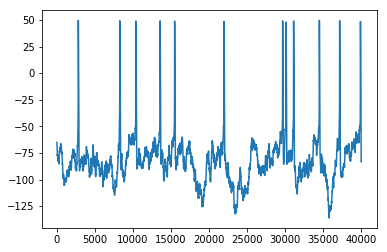

In [7]:
voltage1 = mon.v[0]/mV
plot(voltage1);

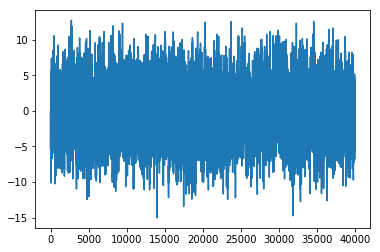

In [8]:
inp_cur1 = mon.I[0]/nA
plot(inp_cur1);

In [9]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([ 27.9 ,  82.46, 103.58, 135.45, 154.5 , 219.38, 296.46, 300.96,
        310.85, 344.7 , 371.35, 398.71])]

In [10]:
start_scope()
G = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
               )
G.v = El

G.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(G)
mon = StateMonitor(G, ['v', 'I'], record=0)

run(400*ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


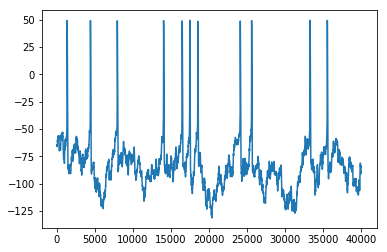

In [11]:
voltage2 = mon.v[0]/mV
plot(voltage2);

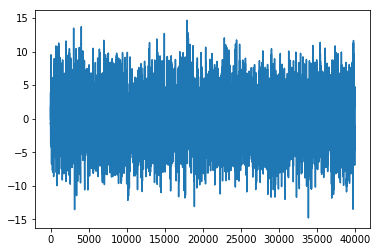

In [12]:
inp_cur2 = mon.I[0]/nA
plot(inp_cur2);

In [13]:
out_spikes2 = [spike_mon.spike_trains()[0]/ms]
out_spikes2

[array([ 13.25,  43.84,  79.14, 139.99, 164.44, 174.38, 184.96, 240.77,
        255.68, 332.52, 355.15])]

In [14]:
out_spikes1

[array([ 27.9 ,  82.46, 103.58, 135.45, 154.5 , 219.38, 296.46, 300.96,
        310.85, 344.7 , 371.35, 398.71])]

In [15]:
out_spikes = [out_spikes1[0], out_spikes2[0]]
out_spikes

[array([ 27.9 ,  82.46, 103.58, 135.45, 154.5 , 219.38, 296.46, 300.96,
        310.85, 344.7 , 371.35, 398.71]),
 array([ 13.25,  43.84,  79.14, 139.99, 164.44, 174.38, 184.96, 240.77,
        255.68, 332.52, 355.15])]

In [16]:
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -1.44333498, -2.32556203, ..., -0.38149723,
         1.76096606,  2.99188671]),
 array([ 0.        ,  0.79225753, -0.83022119, ...,  1.67123925,
         2.04052954,  3.0963489 ])]

## Model Fitting

In [17]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau :volt
        dvt/dt = (a*v - vt) / taut :volt
        alpha : volt (constant)
        a : 1 (constant)
        R : ohm (constant)
        tau : second (constant)
        taut : second (constant)
        '''
reset = '''
v = 0*mV
vt = vt + alpha
'''

In [18]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=300*ms, delta=30*ms)

In [19]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=30,
                     threshold='v > vt',
                     reset=reset,
                     refractory=1.4*ms,
                     param_init={'v': -65*mV},
                     )

In [20]:
result_dict, error = fitter.fit(n_rounds=40,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[5,10]*mV,
                                a = [0.1, 1],
                                R = [1, 100]*Mohm, 
                                tau = [10, 13]*ms,
                                taut = [90, 100]*ms,
                               )

WARNING    "tau" is an internal variable of group "neurons", but also exists in the group-specific namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Round 0: fit (73545905.11093962, 0.011004243499301292, 0.09226624736123658, 0.8314760052508134, 0.005857991282844319) with error: 0.21673101673101658
Round 1: fit (88550841.45720696, 0.011676411301944644, 0.09226624736123658, 0.8266528896987282, 0.005857991282844319) with error: 0.09238909238909221
Round 2: fit (93861018.61995491, 0.011149568808329586, 0.09161701798376921, 0.8182032260649805, 0.005703805529346058) with error: 0.08181167203723572
Round 3: fit (92886280.9992681, 0.011681582805967379, 0.09194928644500924, 0.8008782775265999, 0.005529853959753268) with error: 0.04852936560253607
Round 4: fit (87329867.39272024, 0.011488774557989703, 0.09150599464591436, 0.8692220063467755, 0.005336233857198785) with error: 0.037952022914428785
Round 5: fit (87329867.39272024, 0.011488774557989703, 0.09150599464591436, 0.8692220063467755, 0.005336233857198785) with error: 0.037952022914428785
Round 6: fit (87329867.39272024, 0.011488774557989703, 0.09150599464591436, 0.8692220063467755, 0.0

In [21]:
result_dict

{'R': 76668811.50236201,
 'tau': 0.010519840953877748,
 'taut': 0.09204581027455623,
 'a': 0.9370512167025558,
 'alpha': 0.005388541625431975}

In [22]:
error

0.0034843205574913716

In [23]:
1 - error

0.9965156794425086

In [24]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

WARNING    "tau" is an internal variable of group "neurons_", but also exists in the group-specific namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


spike times: [array([ 20.56,  22.03,  26.61,  28.01,  38.56,  80.55,  81.95,  83.35,
        94.3 , 107.48, 134.44, 137.9 , 154.02, 199.09, 203.95, 218.61,
       254.61, 256.01, 278.72, 293.24, 296.31, 297.71, 299.19, 301.67,
       310.02, 337.63, 345.12, 347.54, 368.5 ]), array([ 12.9 ,  14.3 ,  18.92,  21.56,  25.73,  42.41,  73.08,  76.17,
        86.98, 137.14, 138.54, 141.31, 162.73, 172.45, 174.35, 183.15,
       232.41, 240.49, 253.4 , 320.68, 322.18, 324.08, 326.2 , 332.53,
       354.42, 362.79])]


In [25]:
print(len(out_spikes[0]))
print(len(spikes[0]))

12
29


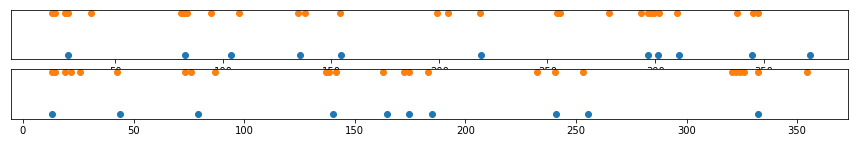

In [26]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);